## Generative Adversarial Networks 101

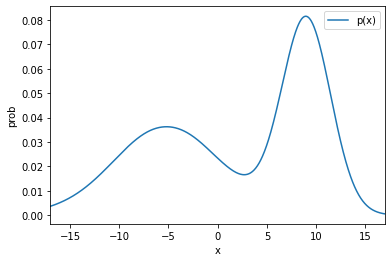

In [7]:
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from sklearn.neighbors import KernelDensity


SHIFT = 0

def sample_real_data(size):
    x1 = torch.randn(size, 1) * 1.5 + 9 + SHIFT
    x2 = torch.randn(size, 1) * 5.0 - 5 + SHIFT

    u = torch.rand(size, 1)
    
    return np.where(u > 0.5, x1, x2)


def plot_data(x):
    kde = KernelDensity(bandwidth=2.0, kernel='gaussian')
    kde.fit(x)

    x_grid = np.linspace(-17 + SHIFT, 17 + SHIFT, 1000)[:, None]
    logprob = kde.score_samples(x_grid)

    plt.xlim([-17 + SHIFT, 17 + SHIFT])
    plt.plot(x_grid, np.exp(logprob))
    
    return kde

X_real = sample_real_data(10000)

plot_data(X_real)

plt.legend(['p(x)'])
plt.xlabel('x')
plt.ylabel('prob')

plt.show()

In [8]:
# Generator is an MLP that converts noise into output data
gen = nn.Sequential(
    nn.Linear(1, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
).cuda()

gen_opt = torch.optim.Adam(gen.parameters(), lr=1e-3, betas=(0.0, 0.999)) # Try using Adam or SGD

# Discriminator is mirroring the architecture of the generator
dis = nn.Sequential(
    nn.Linear(1, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid()
).cuda()

dis_opt = torch.optim.Adam(dis.parameters(), lr=1e-3, betas=(0.0, 0.999)) # TODO

# Binary Cross Entropy for discriminator, for generator we'll non-saturating loss
def calc_loss(real_preds=None, fake_preds=None, net_name=''):
    if net_name == 'dis':
        loss_real = -torch.log(real_preds)
        loss_fake = -torch.log(1 - fake_preds)

        loss = (loss_real + loss_fake) * 0.5
    
    elif net_name == 'gen':
        loss = -torch.log(fake_preds)
    return loss.mean()

In [9]:
def train_dis(batch_size):
    # Forward real
    x_real = torch.from_numpy(sample_real_data(batch_size)).float().cuda()

    real_preds = dis(x_real)
    
    # Forward fake
    z = torch.randn(batch_size, 1).cuda()
    x_fake = gen(z)

    fake_preds = dis(x_fake.detach())

    # Discriminator losses
    loss_D = calc_loss(real_preds, fake_preds, net_name='dis')

    # Discriminator step
    dis_opt.zero_grad()
    loss_D.backward()
    dis_opt.step()

    return loss_D.item()

In [10]:
def train_gen(batch_size):
    # Forward fake
    z = torch.randn(batch_size, 1).cuda()
    x_fake = gen(z)

    fake_preds = dis(x_fake)

    # Generator losses
    loss_G = calc_loss(None, fake_preds, net_name='gen')

    # Generator step
    gen_opt.zero_grad()
    loss_G.backward()
    gen_opt.step()

    return loss_G.item()

Iter 4350


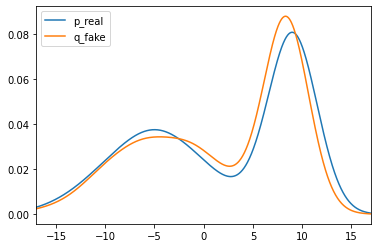

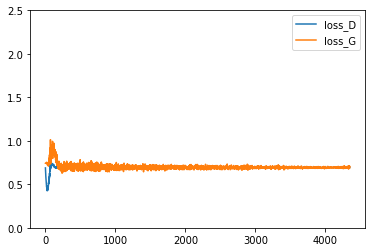

KeyboardInterrupt: ignored

In [11]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline


losses_D_hist = []
losses_G_hist = []

for i in range(1, 100000):    
    for _ in range(1):
        loss_D = train_dis(128)
    
    loss_G = train_gen(128)
    
    losses_D_hist.append(loss_D)
    losses_G_hist.append(loss_G)
    
    if i % 50 == 0:
        clear_output(True)
        print(f'Iter {i}')

        X_real = sample_real_data(10000)
        X_fake = gen(torch.randn(10000, 1).cuda()).detach().cpu().numpy()

        kde_real = plot_data(X_real)
        kde_fake = plot_data(X_fake)
        plt.legend(['p_real', 'q_fake'])
        plt.show()

        plt.plot(losses_D_hist)
        plt.plot(losses_G_hist)
        plt.ylim([0, 2.5])
        plt.legend(['loss_D', 'loss_G'])
        plt.show()